# Test Bandit - 3

Directed exploration testing - UCB and novelty

In [1]:
import shutil
import glob
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib.local_gym import BanditUniform4

from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty

from explorationlib.agent import SoftmaxActor
from explorationlib.agent import DeterministicActor
from explorationlib.agent import BoundedSequentialActor

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save
from explorationlib.score import total_reward
from explorationlib.score import bandit_rmse

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext autoreload
%autoreload 2

# One bandit for all

In [3]:
# Experiment settings
# For all keep the maze the saame
num_experiments = 500
num_steps = 120
seed_value = 4504

# Env
env = BanditUniform4()
env.seed(seed_value)

[4504]

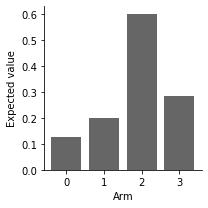

In [4]:
plot_bandit(env, alpha=0.6)

## Compare
BoundedRand, BoundedSeq, Ep

In [26]:
beta = 4
bonus_weight = 1.0

bound = 4 * 5

# Agents
ref = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    Critic(num_inputs=env.num_arms)
)
# UCB
ucb = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticUCB(num_inputs=env.num_arms, bonus_weight=bonus_weight)
)
# Novely
nov = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=beta),
    CriticNovelty(
        num_inputs=env.num_arms, 
        novelty_bonus=1.0,
        bonus_weight=bonus_weight
    )
)
seq = BanditActorCritic(
    BoundedSequentialActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms)
)

# -
agents = [ref, ucb, nov, seq]
names = ["softmax", "softmax-ucb", "softmax-nov", "b-sequential"]
colors = ["blue", "green", "purple", "grey"]

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

b-sequential: 100%|██████████| 500/500 [00:03<00:00, 141.84it/s]


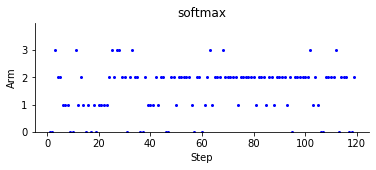

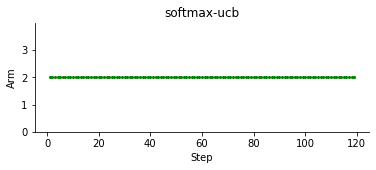

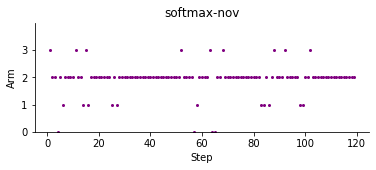

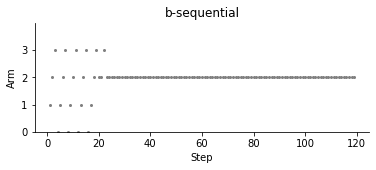

In [27]:
num_experiment = 10
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=120,
        s=4,
        title=name, 
        color=color,
        figsize=(6,2)
        )

## Value

total_reward: 100%|██████████| 500/500 [00:00<00:00, 13545.39it/s]


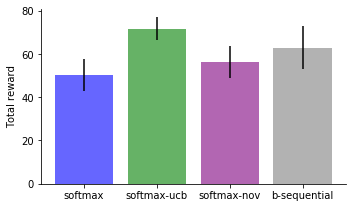

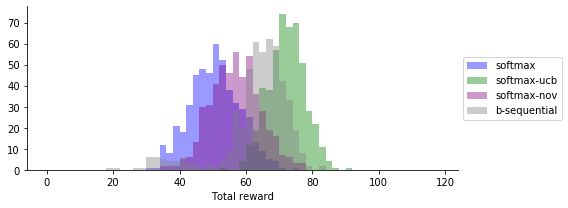

In [33]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(8, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.4, bins=list(range(0, num_steps, 2)))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Total reward")
    plt.tight_layout()
    sns.despine()

## RMSE

bandit_rmse: 100%|██████████| 500/500 [00:00<00:00, 19766.92it/s]


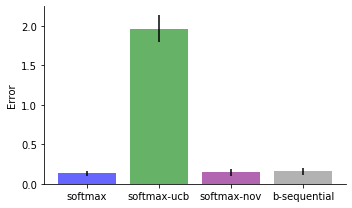

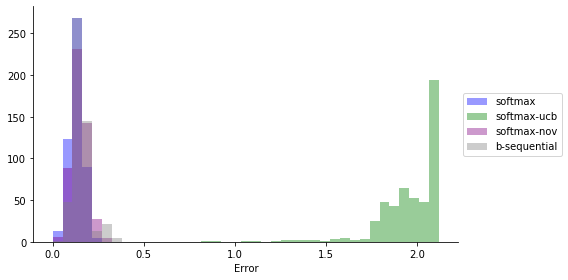

In [34]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = bandit_rmse(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Error")
plt.tight_layout()
sns.despine()

# Dists
bins = np.linspace(0, np.max(scores), 40)
fig = plt.figure(figsize=(8, 4))
for (name, s, c) in zip(names, scores, colors):    
    plt.hist(s, label=name, color=c, alpha=0.4, bins=bins)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Error")
    plt.tight_layout()
    sns.despine()